In [1]:
import numpy as np
import pandas as pd

#시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns

#통계 관련 패키지
import scipy as sp
import scipy.stats

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3
# DataFrame의 출력을 소수점 이하 3자리로 제한 
pd.set_option('precision', 3)

# 추론 통계

## 분산 분석

### 분산의 값에 따른 분포의 변화

In [2]:
centers = [5, 5, 4.5]
colors = 'brg'

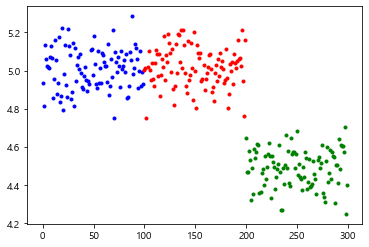

In [5]:
data_1 = []
for i in range(3):
    #정규분포로 시뮬레이션, 평균은 centers[i], 표준 편차는 0.1 데이터는 100개
    data_1.append(sp.stats.norm(centers[i], 0.1).rvs(100))
    plt.plot(np.arange(len(data_1[i])) + i*len(data_1[0]), 
            data_1[i], '.', color = colors[i])

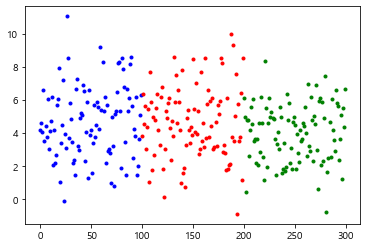

In [6]:
data_2 = []
for i in range(3):
    #정규분포로 시뮬레이션, 평균은 centers[i], 표준 편차는 2 데이터는 100개
    data_2.append(sp.stats.norm(centers[i], 2).rvs(100))
    plt.plot(np.arange(len(data_2[i])) + i*len(data_2[0]), 
            data_2[i], '.', color = colors[i])

### 일원 분산 분석
#### 2개 변수(1개의 독립 변수, 1개의 종속 변수)를 가지고 분류가 의미를 갖는지 확인

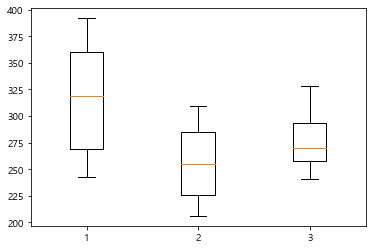

In [10]:
import urllib.request

url = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/altman_910.txt'
data = np.genfromtxt(urllib.request.urlopen(url), delimiter=',')
#print(data)

#그룹별로 분할 - 엽산 수치 값들만 추출
group1 = data[data[:,1] == 1, 0]
group2 = data[data[:,1] == 2, 0]
group3 = data[data[:,1] == 3, 0]

#print(group1)

plot_data = [group1, group2, group3]
ax = plt.boxplot(plot_data)
plt.show()

In [17]:
#일원 분산 분석
F_statistic, p_value = sp.stats.f_oneway(group1, group2, group3)
print(p_value)
print(F_statistic)
#유의 수준을 5% 로 적용
#귀무 가설 - 모든 그룹의 분산이 동일하다
if p_value < 0.05:
    print("귀무 가설을 기각해서 각 그룹의 분산의 차이는 유의미함")
else:
    print("귀무 가설을 기각하지 못해서 각 그룹의 분산의 차이는 무의미함")

0.043589334959178244
3.7113359882669763
귀무 가설을 기각해서 각 그룹의 분산의 차이는 유의미함


In [18]:
from statsmodels.formula.api import ols

df = pd.DataFrame(data, columns=['value', 'treatment'])

model = ols('value ~ C(treatment)', df).fit()

import statsmodels.api as sm
print(sm.stats.anova_lm(model)) #유의 확률은 0.044

                df     sum_sq   mean_sq      F  PR(>F)
C(treatment)   2.0  15515.766  7757.883  3.711   0.044
Residual      19.0  39716.097  2090.321    NaN     NaN


### 이원 분산 분석

<AxesSubplot:title={'center':'head_size'}, xlabel='fetus'>

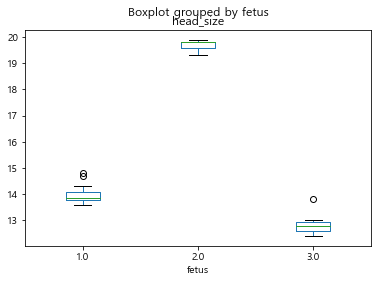

In [21]:
inFile = 'altman_12_6.txt'
url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/'
url = url_base + inFile
data = np.genfromtxt(urllib.request.urlopen(url), delimiter=',')
#print(data)

df = pd.DataFrame(data, columns=['head_size', 'fetus', 'observer'])
#print(df)

df.boxplot(column='head_size', by='fetus', grid=False)

In [22]:
lm = ols('head_size ~ C(fetus) + C(observer) + C(fetus):C(observer)', 
        df).fit()
print(sm.stats.anova_lm(lm))

#p-value 값이 작아서 분산의 차이가 무의미

                        df   sum_sq  mean_sq         F     PR(>F)
C(fetus)               2.0  324.009  162.004  2113.101  1.051e-27
C(observer)            3.0    1.199    0.400     5.211  6.497e-03
C(fetus):C(observer)   6.0    0.562    0.094     1.222  3.296e-01
Residual              24.0    1.840    0.077       NaN        NaN


## 카이 제곱 검정

### 재표본 추출 알고리즘

In [38]:
#데이터 읽어오기
click_rate = pd.read_csv('./data/click_rates.csv')
#print(click_rate)

#관측치
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
#print(clicks)

#기대치
row_average = clicks.mean(axis=1)
expectations = pd.DataFrame({'Headline A': row_average, 
                            'Headline B': row_average, 
                            'Headline C' : row_average})
#print(expectations)

#샘플링 할 데이터를 생성
import random

box = [1] * 34
box.extend([0] * 2966)
#print(box[:10])

#랜덤하게 섞기
random.shuffle(box)
#print(box[:10])


#카이 제곱 통계량 계산 함수
def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append(
            [(observe - expect) ** 2 / expect for observe in row])
    return np.sum(pearson_residuals)

#클릭의 기대치
expected_clicks = 34/3
#클릭하지 않을 기대치
expected_noclicks = 1000 - expected_clicks

expected = [expected_clicks, expected_noclicks]

#관측치의 카이 제곱 통계량 계산
chi2observed = chi2(clicks.values, expected)
print("관측치의 카이 제곱 통계량:", chi2observed)

#샘플링한 데이터로 카이 제곱 통계량을 구해주는 함수
def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000))
                     , sum(random.sample(box, 1000))
                     , sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(10000)]

#p-value 계산
#샘플링한 데이터의 카이 제곱 통계량 값이 관측치의 카이 제곱 통계량보다
#큰 경우의 확률이 p_value
p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(p_value)

관측치의 카이 제곱 통계량: 1.6659394708658917
0.4838


### scipy 의 카이 제곱 검정

In [36]:
chisq, pvalue, df, expected = sp.stats.chi2_contingency(clicks)
print("관측치의 카이 제곱 통계량:", chisq)
print("유의 확률:", pvalue)
print("자유도:", df) #3개의 그룹이 있어서 하나의 그룹을 제외하면 2
print("기대치:", expected)

관측치의 카이 제곱 통계량: 1.6659394708658917
유의 확률: 0.4347562562343731
자유도: 2
기대치: [[ 11.333  11.333  11.333]
 [988.667 988.667 988.667]]


### 일원 카이 제곱 검정

In [45]:
#주사위 게임을 했을 때 아래와 같은 결과가 나오면 이것은 공정한 주사위인가
N = 60
K = 6
#주사위 기대 확률
theta_0 = np.ones(K)/K
print(theta_0)

#실제 데이터
np.random.seed(42)
x = np.random.choice(K, N, p=theta_0)
print(x)

#횟수 카운트
n = np.bincount(x, minlength=K)
print(n)

#일원 카이 제곱 검정
result = sp.stats.chisquare(n)
print(result)
print(result.pvalue)

#pvalue 가 0.05보다 커서 귀무 가설을 기각할 수 없음
#이 주사위는 공평합니다.

[0.167 0.167 0.167 0.167 0.167 0.167]
[2 5 4 3 0 0 0 5 3 4 0 5 4 1 1 1 1 3 2 1 3 0 1 2 2 4 1 3 3 0 3 1 0 5 5 4 1
 0 4 2 0 2 0 5 1 3 1 3 3 1 5 4 5 5 3 5 0 1 0 1]
[12 14  6 11  7 10]
Power_divergenceResult(statistic=4.6000000000000005, pvalue=0.4666162741153308)
0.4666162741153308


In [46]:
#5가지 스포츠 음료에 대한 선호도를 조사
n = [41, 30, 51, 71, 61]
result = sp.stats.chisquare(n)
print(result)
print(result.pvalue)
#pvalue 가 0.05보다 작으므로 귀무 가설을 기각
#선호도에 차이가 있습니다.

Power_divergenceResult(statistic=20.488188976377952, pvalue=0.00039991784008227264)
0.00039991784008227264


## Z 검정

### 모집단의 평균 과 표준 편차를 알고 있을 때 새로운 표본의 평균이 모집단의 평균과 차이가 없는지 여부를 검정

### 단일 표본 z 검정

In [52]:
#샘플 데이터를 생성
np.random.seed(0)
N = 10
mu_0 = 0
x = sp.stats.norm(mu_0).rvs(N)
print(x)

[ 1.764  0.4    0.979  2.241  1.868 -0.977  0.95  -0.151 -0.103  0.411]


In [53]:
#단일 표본 z 검정을 수행해주는 함수
def ztest_1samp(x, sigma2 = 1, mu = 0):
    z = (x.mean() - mu) / np.sqrt(sigma2/len(x))
    return z, 2 * sp.stats.norm().sf(np.abs(z))

In [54]:
ztest_1samp(x)

(2.3338341854824276, 0.019604406021683538)

In [55]:
#샘플의 개수를 늘림
N = 100
x = sp.stats.norm(mu_0).rvs(N)
ztest_1samp(x)

(0.18477539979956745, 0.8534052037078499)

### 비율 검정

In [57]:
from statsmodels.stats.proportion import proportions_ztest

result = proportions_ztest(count=135, nobs=150, value=110/150)
print(result)

(6.80413817439772, 1.0165593635824276e-11)


## 정규성 검정

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


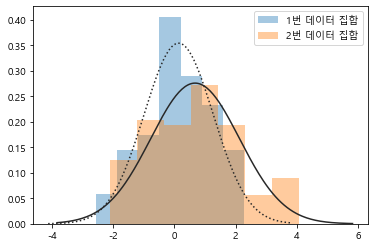

KstestResult(statistic=0.23, pvalue=0.05550723364321564)


In [60]:
np.random.seed(0)

N1 = 50
N2 = 100

#평균이 0 표준편차가 1인 정규 분포 데이터 50개 생성
x1 = sp.stats.norm(0,1).rvs(N1)
#평균이 0.5 표준편차가 1.5인 정규 분포 데이터 100개 생성
x2 = sp.stats.norm(0.5,1.5).rvs(N2)

ax = sns.distplot(x1, kde=False, fit=sp.stats.norm, label='1번 데이터 집합')
ax = sns.distplot(x2, kde=False, fit=sp.stats.norm, label='2번 데이터 집합')
ax.lines[0].set_linestyle(":")
plt.legend()
plt.show()

#x1 과 x2 의 분포가 같은지 확인
print(sp.stats.ks_2samp(x1, x2))

#유의 수준 5% 이면 pvalue 가 더 크므로 귀무가설을 채택
#2개의 데이터 분포는 동일

# 붓꽃 데이터 셋

In [63]:
from sklearn.datasets import load_iris

iris = load_iris()
print(iris.data)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

## 데이터 유형

### 스칼라 데이터

In [64]:
print(iris.data[0, 0])

5.1


### 벡터 데이터

In [70]:
#기본적인 표현법
x1 = np.array([[5.1], [3.5], [1.4], [0.2]])
print(x1)

#1차원 배열도 벡터로 간주
x2 = np.array([5.1, 3.5, 1.4, 0.2])
print(x2)

#다차원을 1차원으로 변경
print(x1.flatten())
print(x1.reshape(-1))

#1차원을 2차원으로 변경 - 4, 1은 4행 1열로 변경하는 것이고 
#4, -1 은 4행으로 변경
print(x2.reshape((4, 1)))
print(x2.reshape((4, -1)))

[[5.1]
 [3.5]
 [1.4]
 [0.2]]
[5.1 3.5 1.4 0.2]
[5.1 3.5 1.4 0.2]
[5.1 3.5 1.4 0.2]
[[5.1]
 [3.5]
 [1.4]
 [0.2]]
[[5.1]
 [3.5]
 [1.4]
 [0.2]]


### 행렬

In [71]:
matrix = np.array([[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2]])
print(matrix)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]]
